In [1]:
%load_ext autoreload
%autoreload 2

from functools import partial

from transformer_lens import HookedTransformer

from MIB_circuit_track.circuit_loading import load_graph_from_json
from MIB_circuit_track.dataset import HFEAPDataset
from MIB_circuit_track.metrics import get_metric
from eap.evaluate import evaluate_graph, evaluate_baseline 
from run_evaluation import evaluate_area_under_curve

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/alestolfo/.miniconda3/envs/mib/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
model = HookedTransformer.from_pretrained("gpt2-small", device="mps")
model.cfg.use_split_qkv_input = True
model.cfg.use_attn_result = True
model.cfg.use_hook_mlp_in = True

Loaded pretrained model gpt2-small into HookedTransformer


In [4]:
g = load_graph_from_json('circuits/ioi-eap-ig.json')

In [5]:
dataset = HFEAPDataset("yanivnik/arithmetics_mib", model.tokenizer, task="arithmetic", num_examples=None)
dataloader = dataset.to_dataloader(20)
metric_fn = get_metric("logit_diff", "arithmetic", model.tokenizer, model)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Filter:   0%|          | 0/400 [00:00<?, ? examples/s]


KeyError: 'label'

In [7]:
baseline = evaluate_baseline(model, dataloader, partial(metric_fn, loss=False, mean=False)).mean().item()
results = evaluate_graph(model, g, dataloader, partial(metric_fn, loss=False, mean=False)).mean().item()

print(f"Faithfulness: {results / baseline}")

 60%|██████    | 3/5 [00:00<00:00, 23.57it/s]

100%|██████████| 5/5 [00:00<00:00, 12.39it/s]

Faithfulness: 0.8137911680392587


In [8]:
results = evaluate_area_under_curve(model, g, dataloader, partial(metric_fn, loss=False, mean=False))

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:00<00:00, 15.31it/s]


Computing results for 0.1% of edges (N=32)


100%|██████████| 5/5 [00:00<00:00, 13.05it/s]


0.023235465441070358
Computing results for 0.2% of edges (N=64)


100%|██████████| 5/5 [00:00<00:00, 12.61it/s]


0.23934712323155205
Computing results for 0.5% of edges (N=162)


100%|██████████| 5/5 [00:00<00:00, 12.91it/s]


0.49878704706434146
Computing results for 1.0% of edges (N=324)


100%|██████████| 5/5 [00:00<00:00, 12.04it/s]


0.8029948468276173
Computing results for 2.0% of edges (N=649)


100%|██████████| 5/5 [00:00<00:00, 12.16it/s]


0.881251360232674
Computing results for 5.0% of edges (N=1624)


100%|██████████| 5/5 [00:00<00:00, 12.50it/s]


0.9202821820867104
Computing results for 10.0% of edges (N=3249)


100%|██████████| 5/5 [00:00<00:00, 12.40it/s]


0.9356659044514378
Computing results for 20.0% of edges (N=6498)


100%|██████████| 5/5 [00:00<00:00, 12.44it/s]


0.9672387596772917
Computing results for 50.0% of edges (N=16245)


100%|██████████| 5/5 [00:00<00:00, 12.42it/s]


0.9781279677803796
Computing results for 100% of edges (N=32491)


100%|██████████| 5/5 [00:00<00:00, 12.33it/s]

1.0
Weighted edge counts: [21.0, 45.0, 146.0, 276.0, 608.0, 1574.0, 3212.0, 6498.0, 16245.0, 32491.0]


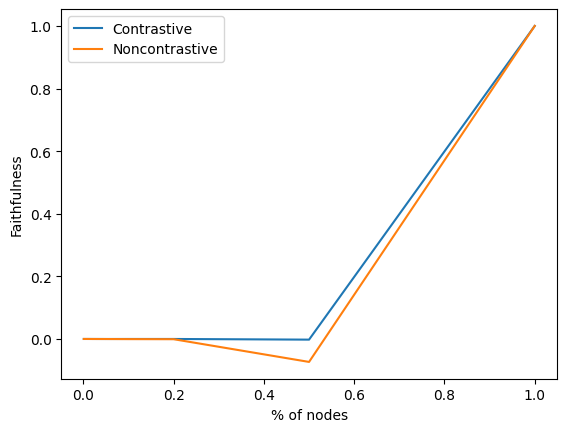

In [9]:
import matplotlib.pyplot as plt

pcts = (.001, .002, .005, .01, .02, .05, .1, .2, .5, 1)
y_contrastive = [-4.3432811613057716e-07, 7.05457144550756e-07, -7.496209742841024e-07, 7.052533849463576e-07,
     -1.8585725065375747e-05, -9.005726983212978e-05, 2.1746788604272084e-06, -1.0390447043277758e-05,
     -0.002129602874543343, 1.0]
y_noncontrastive = [2.95713277363795e-06, 1.4721485526194549e-06, 1.715279203456343e-06, -6.437337602558278e-06,
                    -0.00010388284106108161, -0.00018730482812955983, -0.000474848496574308, -0.0007699631375741954,
                    -0.07332578102989909, 1.0]
plt.xlabel("% of nodes")
plt.ylabel("Faithfulness")
plt.plot(pcts, y_contrastive, label="Contrastive")
plt.plot(pcts, y_noncontrastive, label="Noncontrastive")
plt.legend()

plt.show()